## Necesary conditions for Max Clique 
### Install pyQUBO from Recruit Communications Co. Ltd.
    pip install pyqubo
### Install openJij from Jij Inc.  (startup from Tohoku University)
    pip install -U cmake (in google collaboratory, update cmake)
    pip install open jij

### Add networkx for dealing with graph theory

        pip install networkx

# Solve Max Clique

### import pyQUBO, openJij, numpy and matplotlib

In [128]:
from pyqubo  import Array,Constraint, Placeholder
import openjij as jij
import numpy as np
import matplotlib.pyplot as plt

Array, Constrains and Placeholders are convenient classes from pyQUBO

### import networkx

In [109]:
import networkx as nx

### Prepare some graph

In [110]:
nodes = [0, 1, 2, 3, 4, 5]
edges = [
    (0, 1), (1, 2), (2, 4), (1, 3),
    (3, 4), (4, 5), (3, 5)
    ]

### Set nodes and edges on Graph G

In [111]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

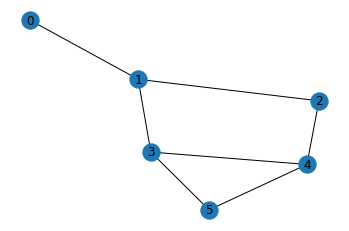

In [112]:
nx.draw_networkx(G)
plt.axis("off")
plt.show()

### Prepare binary variables

In [113]:
N = 6
K = 3
vartype = "BINARY"
q = Array.create("q",shape=N,vartype=vartype)

"q" is name of variables  
shape specifies the shape of variables as vector, matrix, or...  
vartype selects -1 or 1 by "SPIN" and 0 or 1by "BINARY"

In [114]:
print(q)

Array([Binary(q[0]), Binary(q[1]), Binary(q[2]), Binary(q[3]), Binary(q[4]), Binary(q[5])])


### Define cost function

In [115]:
E1 = Constraint((np.sum(q)-K)**2,"K")

In [116]:
E2 = 0
for e in edges:
    E2 += - q[e[0]]*q[e[1]]
E2 += 0.5*K*(K-1)

In [117]:
Lam = Placeholder('Lam')
E_cost = Lam*E1+E2

### Compile the cost function

In [118]:
model = E_cost.compile()

### Get qubo matrix

In [119]:
feed_dict = {'Lam': 5.0}
Q, offset = model.to_qubo(feed_dict=feed_dict)

### Prepare simulation of quantum annealing

In [121]:
sampler = jij.SQASampler(beta=10.0, gamma=1.0, trotter=4, step_length=10, step_num=10, schedule=None, iteration=1)

This is done by quantum Monte-Carlo simulation  
gamma = strength of quantum fluctuation  
iteration = number of reads  
step_num = number of MCS  
trotter = Trotter number  
step_length = length of MCS in the same gamma   

### Let's simulate quantum annealing

In [122]:
response = sampler.sample_qubo(Q)

### Show results

In [123]:
print(response)

iteration : 1, minimum energy : -48.0, var_type : BINARY
indices: ['q[3]', 'q[1]', 'q[5]', 'q[2]', 'q[0]', 'q[4]'] 
minmum energy state sample : [1, 0, 1, 0, 0, 1]


### minimum sample

In [124]:
response.samples[0]

{'q[3]': 1, 'q[1]': 0, 'q[5]': 1, 'q[2]': 0, 'q[0]': 0, 'q[4]': 1}

### decode solution through openJij and pyQUBO

In [125]:
def decode_spin(sol,vartype,feed_dict = None):
    dsol, broken, energy = model.decode_solution(sol, feed_dict = feed_dict, vartype=vartype)
    spin = np.zeros(N)
    for keys in dsol["q"]:
        spin[keys] = dsol["q"][keys]
    return spin,energy 

We define an original function for decoding the solution from openJij with pyQUBO into a standard expression.  
reposense.min["min_state"] is written on the indices in openJij.
Here we arrange the original order of the variables by our function.

In [126]:
spin,energy = decode_spin(response.samples[0],vartype=vartype,feed_dict = feed_dict)

### show resulting graph

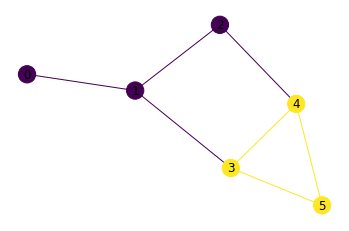

In [127]:
edge_colors = [(spin[edge[0]]==1 and spin[edge[1]] == 1) >0 for edge in G.edges()]
node_colors = [spin[node]>0 for node in G.nodes()]

nx.draw_networkx(G,node_color=node_colors,edge_color=edge_colors)
plt.axis("off")
plt.show()